## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install datasets matplotlib pandas pillow tqdm

# # Install older pyzmq and jupyter client versions
# !pip install --upgrade "jupyter_client<8" "pyzmq<25"

# # Install utility packages
# !pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor, move_data_to_device
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes, draw_keypoints
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'labelme-keypoint-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/labelme-keypoint-toy-dataset
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/labelme-keypoint-toy-dataset.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/labelme-keypoint-toy-dataset/resolve/main/labelme-keypoint-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [6]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

,Image File,Annotation File
0,133196.jpg,133196.json
1,245035.jpg,245035.json
2,245036.jpg,245036.json
3,247937.jpg,247937.json
4,3172614.jpg,3172614.json


### Get Image File Paths

In [7]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 38


,0
133196,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/133196.jpg
245035,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245035.jpg
245036,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/245036.jpg
247937,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/247937.jpg
3172614,/mnt/980_1TB_2/Datasets/labelme-keypoint-toy-dataset/3172614.jpg


### Get Image Annotations

In [8]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
133196,5.3.1,{},"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",133196.jpg,None,768,960
245035,5.3.1,{},"[{'label': 'nose', 'points': [[334.4587155963303, 319.57798165137615]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245035.jpg,None,1152,768
245036,5.3.1,{},"[{'label': 'nose', 'points': [[226.8571428571429, 240.80357142857144]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",245036.jpg,None,1120,768
247937,5.3.1,{},"[{'label': 'nose', 'points': [[454.6585365853659, 230.03658536585363]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",247937.jpg,None,768,1152
3172614,5.3.1,{},"[{'label': 'nose', 'points': [[539.4146341463414, 608.0853658536585]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]",3172614.jpg,None,768,1152


### Inspecting the Class Distribution

#### Get image classes

In [9]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [10]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,nose


#### Visualize the class distribution

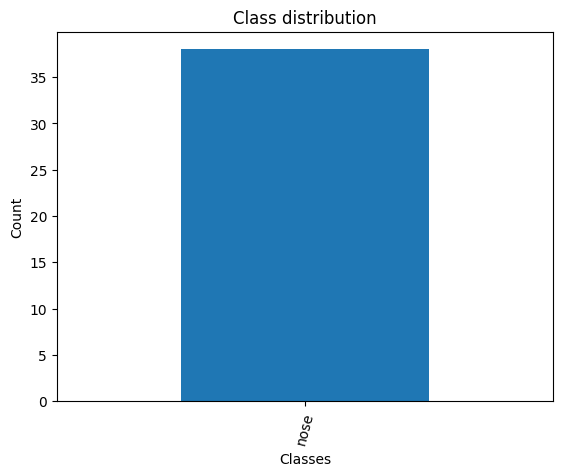

In [11]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

#### Add a background class

In [12]:
# # Prepend a `background` class to the list of class names
# class_names = ['background']+class_names

# # Display labels using a Pandas DataFrame
# pd.DataFrame(class_names)

### Visualizing Keypoint Annotations

#### Generate a color map

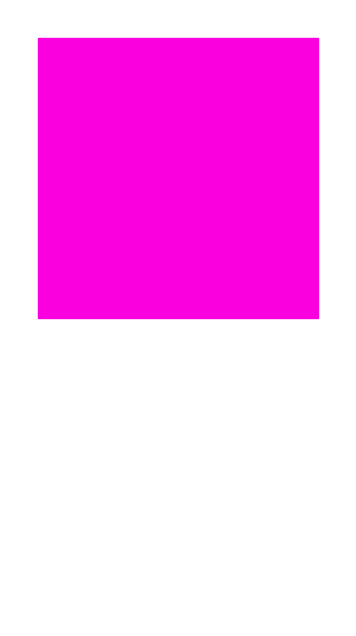

In [13]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [14]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [15]:
draw_bboxes = partial(draw_bounding_boxes, fill=True, width=2, font=font_file, font_size=25)

In [16]:
# draw_points = partial(draw_keypoints, connectivity=None, radius=2, width=1)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (960, 768)


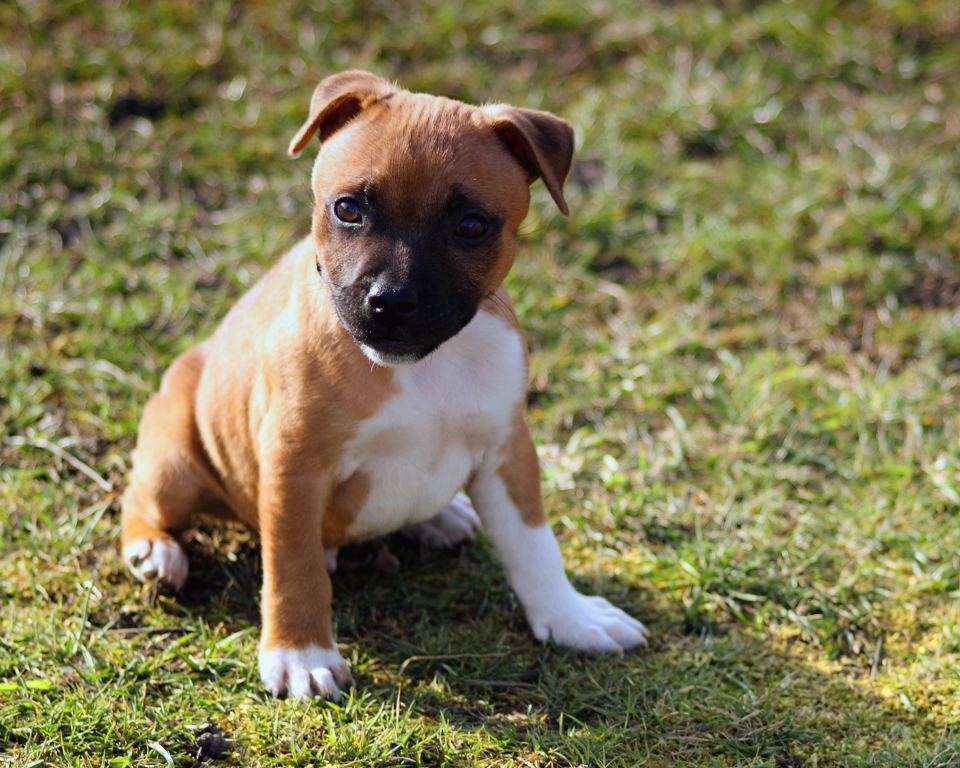

In [17]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [18]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,133196
version,5.3.1
flags,{}
shapes,"[{'label': 'nose', 'points': [[386.70731707317077, 297.109756097561]], 'group_id': None, 'description': '', 'shape_type': 'point', 'flags': {}}]"
imagePath,133196.jpg
imageData,None
imageHeight,768
imageWidth,960


#### Annotate sample image

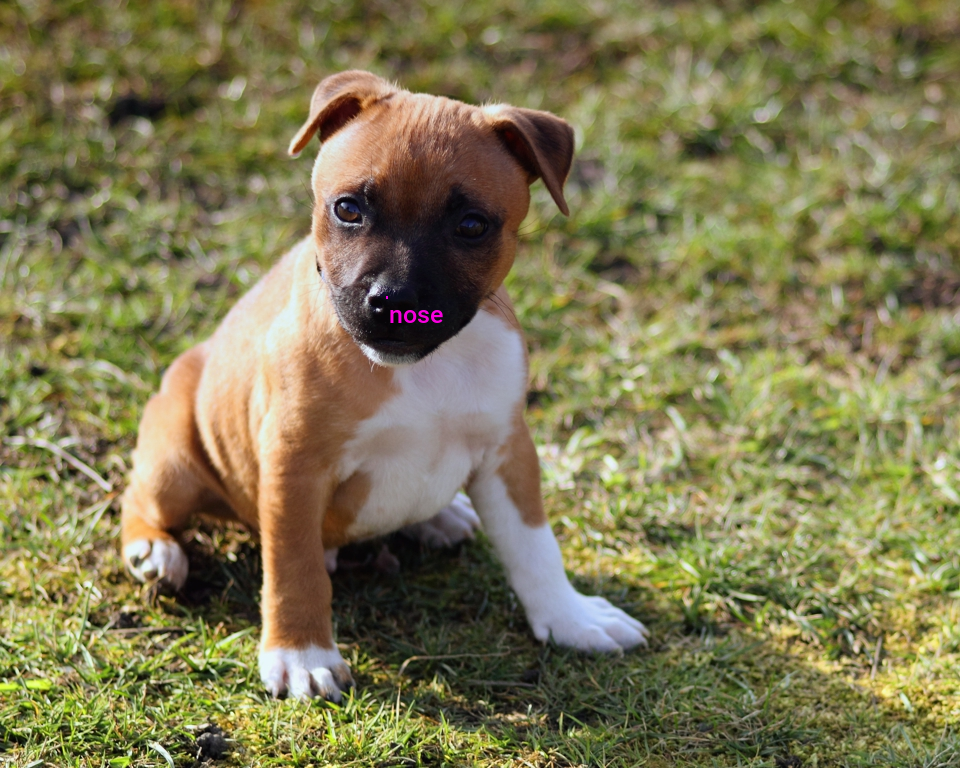

In [19]:
# Extract the labels and bounding box annotations for the sample image
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
keypoints = torch.tensor(np.array([shape['points'] for shape in annotation_df.loc[file_id]['shapes']])).reshape(1,2)
keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2)), dim=1)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(keypoints_bboxes), 'cxcywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [20]:
# Set training image size to a multiple of the max stride value
train_sz = 384

#### Initialize the transforms

In [21]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [22]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

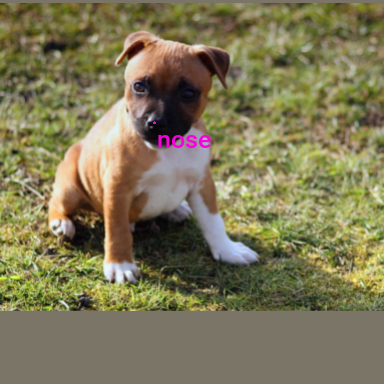

Source Image:,"(960, 768)"
Cropped Image:,"(960, 768)"
Resized Image:,"(383, 307)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [23]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy'), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [24]:
class LabelMeKeypointDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding bounding box annotations and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the LabelMeKeypointDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]
        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]
        # Load the image and its target (bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')
        
        # Extract the labels and bounding box annotations for the sample image
        keypoints = torch.tensor(np.array([shape['points'] for shape in annotation_df.loc[file_id]['shapes']])).reshape(1,2)
        keypoints_bboxes = torch.cat((keypoints, torch.ones(len(keypoints), 2)), dim=1)
                
        # Convert bounding box coordinates from [center-x, center-y, width, height] to [xmin, ymin, xmax, ymax]
        bbox_tensor = torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy')
        # Create a BoundingBoxes object with the bounding boxes
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        
        # Convert the class labels to indices
        labels = torch.Tensor([self._class_to_idx[label] for label in class_to_idx.keys()])
        
        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [25]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        transforms.Identity(),
        # transforms.RandomChoice([
        #     transforms.RandomZoomOut(fill= (123, 117, 104), side_range=(1.125, 1.5)), 
        #     iou_crop
        # ], p=[0.3, 0.7]),
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        # transforms.RandomGrayscale(),
        # transforms.RandomEqualize(),
        # transforms.RandomPosterize(bits=3, p=0.5),
        # transforms.RandomZoomOut(fill=(123, 117, 104), side_range=(1.0, 1.5)),
        transforms.RandomChoice([
            transforms.RandomRotation(degrees=20, fill=(123, 117, 104)),
            transforms.RandomPerspective(distortion_scale=0.3, p=1.0, fill=(123, 117, 104)),
        ]),
        # transforms.ScaleJitter(train_sz)
    ],
)

resize_tfm = transforms.Resize(train_sz, antialias=True)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_tfm, 
    pad_square,
    transforms.Resize([train_sz]*2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    # transforms.SanitizeBoundingBoxes(),
    # transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_tfm,
    final_tfms
])

### Initialize Dataset

In [26]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = LabelMeKeypointDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,38


### Inspect Samples

**Inspect training set sample**

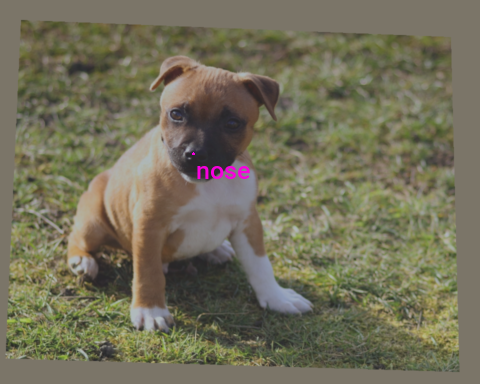

In [27]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

In [28]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def convert_keypoints(keypoints):
    """Convert keypoints from custom format to CVAT format."""
    converted = []
    for image_keypoints in keypoints:
        image_converted = []
        for keypoint in image_keypoints:
            for label, coords in keypoint.items():
                cvat_keypoint = {
                    "label": label,
                    "points": ",".join(map(str, coords))  # x1,y1,x2,y2,...
                }
                image_converted.append(cvat_keypoint)
        converted.append(image_converted)
    return converted

def create_cvat_xml(labels, keypoints, colors, dims, image_names, file_name):
    converted_keypoints = convert_keypoints(keypoints)

    annotations = ET.Element("annotations")
    version = ET.SubElement(annotations, "version")
    version.text = "1.1"

    # Meta information (modify as needed)
    meta = ET.SubElement(annotations, "meta")
    task = ET.SubElement(meta, "task")
    ET.SubElement(task, "id").text = "1"  # Example ID
    ET.SubElement(task, "name").text = "Image Annotation Task"
    ET.SubElement(task, "size").text = str(len(dims))
    ET.SubElement(task, "mode").text = "annotation"
    ET.SubElement(task, "overlap").text = "0"

    # Defining labels
    labels_elem = ET.SubElement(task, "labels")
    for label, color in zip(labels, colors):
        label_elem = ET.SubElement(labels_elem, "label")
        # ... (Label details)
        ET.SubElement(label_elem, "type").text = "points"  # Change to 'points'

    # Images and keypoints
    for i, (dim, keypoints_per_image, image_name) in enumerate(zip(dims, converted_keypoints, image_names)):
        image_elem = ET.SubElement(annotations, "image", id=str(i), name=image_name, width=str(dim[0]), height=str(dim[1]))
        for keypoint in keypoints_per_image:
            ET.SubElement(image_elem, "points", label=keypoint["label"], points=keypoint["points"], occluded="0")

    # Writing to file with pretty print
    with open(file_name, "w") as file:
        file.write(prettify(annotations))

In [29]:
points = [[{ shape['label'] : np.array(shape['points']).reshape(2).tolist()} for shape in shapes] for shapes in annotation_df['shapes']]

In [30]:
points

[[{'nose': [386.70731707317077, 297.109756097561]}],
 [{'nose': [334.4587155963303, 319.57798165137615]}],
 [{'nose': [226.8571428571429, 240.80357142857144]}],
 [{'nose': [454.6585365853659, 230.03658536585363]}],
 [{'nose': [539.4146341463414, 608.0853658536585]}],
 [{'nose': [506.95121951219505, 282.4756097560975]}],
 [{'nose': [859.1951219512196, 286.1341463414634]}],
 [{'nose': [401.3228346456693, 330.251968503937]}],
 [{'nose': [458.04844290657434, 548.7889273356401]}],
 [{'nose': [626.609756097561, 656.8658536585365]}],
 [{'nose': [629.6585365853658, 293.4512195121951]}],
 [{'nose': [654.4444444444443, 340.3131313131313]}],
 [{'nose': [264.4878048780487, 476.6341463414634]}],
 [{'nose': [854.0487804878048, 339.79268292682923]}],
 [{'nose': [590.6341463414634, 489.79268292682923]}],
 [{'nose': [486.2439024390244, 357.4756097560975]}],
 [{'nose': [524.780487804878, 422.10975609756093]}],
 [{'nose': [676.0, 442.8414634146341]}],
 [{'nose': [672.3414634146341, 409.3048780487805]}],


In [31]:
colors = int_colors
dims = annotation_df[['imageHeight', 'imageWidth']].values.tolist()

In [32]:
create_cvat_xml(class_names, points, colors, dims, annotation_df.index.tolist(), "output.xml")